# Outline
- [Part 1:  import packages](#1) 
    
    
- [Part 2:  prepare functions](#2)

    - [2.1  create train & validation generators function](#2.1)
    - [2.2  build model function](#2.2)
    - [2.3  learning rate scadular](#2.3)
    - [2.4  model training function](#2.4)
    - [2.5  load test data](#2.5)
    - [2.6  draw training graph function](#2.6)
    - [2.7  draw confusion_matrix function](#2.7)
    - [2.8  print classification report function](#2.8)
    
    
- [Part 3:  train the model on the original data](#3)

    - [3.1  model on imbalanced data](#3.1)
        - [3.1.1  model architecture](#3.1.1)
        - [3.1.2  train the model](#3.1.2)
        - [3.1.3  train results](#3.1.3)
        - [3.1.4  test results](#3.1.4)
        
    - [3.2  model on oversampled data](#3.2)
        - [3.2.1  model architecture](#3.2.1)
        - [3.2.2  train the model](#3.2.2)
        - [3.2.3  train results](#3.2.3)
        - [3.2.4  test results](#3.2.4)
        
    - [3.3  model on undersampled data](#3.3)
        - [3.3.1  model architecture](#3.3.1)
        - [3.3.2  train the model](#3.3.2)
        - [3.3.3  train results](#3.3.3)
        - [3.3.4  test results](#3.3.4)

- [Part 4:  train the model on the paper preprocessed data](#4)

    - [4.1  model on imbalanced data](#4.1)
        - [4.1.1  model architecture](#4.1.1)
        - [4.1.2  train the model](#4.1.2)
        - [4.1.3  train results](#4.1.3)
        - [4.1.4  test results](#4.1.4)
        
    - [4.2  model on oversampled data](#4.2)
        - [4.2.1  model architecture](#4.2.1)
        - [4.2.2  train the model](#4.2.2)
        - [4.2.3  train results](#4.2.3)
        - [4.2.4  test results](#4.2.4)
        
    - [4.3  model on undersampled data](#4.3)
        - [4.3.1  model architecture](#4.3.1)
        - [4.3.2  train the model](#4.3.2)
        - [4.3.3  train results](#4.3.3)
        - [4.3.4  test results](#4.3.4)



<a name="1"></a>
##  <span style="color:blue"> **import packages** </span>

In [1]:
import numpy as np
from tqdm import tqdm
import glob
import pickle
import math
#for images preprocessing
# from sklearn.model_selection import train_test_split
# import cv2
# from skimage.feature import hog,canny
# from skimage.color import rgb2gray

#for model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for model evaluation and visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#to check if using the gpu
tf.test.is_built_with_cuda()

True

<a name="2"></a>
##  <span style="color:blue"> **prepare functions** </span>

<a name="2.1"></a>

In [3]:

# build train & validation generator 
def create_generators(train_path):
    train_datagen  = ImageDataGenerator(
                                        rescale=1 / 255.0,
                                        rotation_range=30,
                                        zoom_range = 0.2,
                                        validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='training',
        shuffle=True,
    )

    valid_datagen=ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    validation_split=0.2)

    valid_generator = valid_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='validation',
    )
    return train_generator ,valid_generator

<a name="2.2"></a>

In [17]:
# build the model
def build_model():
    model = Sequential()

    # Input layer
    model.add(InputLayer(input_shape = (224,224,3)))


    # Adding layers
    model.add(Conv2D(filters = 32,   kernel_size  = (3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 64,   kernel_size  = (3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 128,  kernel_size  = (3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
    model.add(Dropout(0.4))


    model.add(Flatten())


    # Adding full connected layer (dense)
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))


    # Adding output layer
    model.add(Dense(units = 1, activation='sigmoid'))


    return model

<a name="2.3"></a>

In [5]:
EPOCHS = 40

LEARNING_RATE = 3e-5
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE

LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5
 

In [6]:
# scadular for modifing learning rate during training
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

# def scheduler(epoch, lr):
#     if epoch %2 != 0:
#          return lr
#     else:
#          return lr* tf.math.exp(-0.1)
# #         

<a name="2.4"></a>

In [7]:
#train the model
def train_model(model, train_generator, valid_generator):
    
    checkpoint_filepath = './my_model/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

    callback = [LearningRateScheduler(lrfn),model_checkpoint_callback]
    
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history= model.fit(train_generator ,validation_data=(valid_generator) ,epochs=EPOCHS,callbacks=callback)
    return history

<a name="2.5"></a>

In [24]:
# load test data
x_test=pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl', 'rb'))

In [22]:
# test data for paper preprocessed
x_test=pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test_pre1.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl', 'rb'))

<a name="2.6"></a>

In [8]:
# graph of (train & validation) (accuracy & loss) per training epochs
def draw_train_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a name="2.7"></a>

In [9]:
# draw the confusion_matrix for testing data 
def draw_confusion_matrix(model,x_test,y_test):

    y_test_predict=model.predict(x_test)
    y_test_predict = np.around(y_test_predict)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_test_predict)


    plt.figure(figsize = (10,7))
    sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')
    return y_test_predict

<a name="2.8"></a>

In [10]:
# print the classification_report for testing data 
def print_classification_report(y_test,  y_test_predict):
    target_names = ['abnormal', 'normal']
    print(classification_report(y_test,  y_test_predict,target_names=target_names))

<a name="3"></a>
##  <span style="color:blue"> **train the model on the original data** </span>

<a name="3.1"></a>

### on original imbalanced data

In [11]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/imbalanced/training_data'

In [12]:
train_generator,valid_generator = create_generators(train_path)

Found 8017 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


In [18]:
model1=build_model()

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 64)    

<a name="2.1"></a>

### model complie & train

In [19]:
history=train_model(model1,train_generator,valid_generator)

Epoch 1/40
502/502 [==============================] - 97s 190ms/step - loss: 1.0248 - accuracy: 0.4962 - val_loss: 0.6345 - val_accuracy: 0.6795 - lr: 1.0000e-08
Epoch 2/40
502/502 [==============================] - 85s 169ms/step - loss: 0.7016 - accuracy: 0.6920 - val_loss: 1.3729 - val_accuracy: 0.3774 - lr: 1.0007e-05
Epoch 3/40
502/502 [==============================] - 87s 174ms/step - loss: 0.6572 - accuracy: 0.7102 - val_loss: 2.2114 - val_accuracy: 0.4493 - lr: 2.0003e-05
Epoch 4/40
502/502 [==============================] - 90s 179ms/step - loss: 0.5912 - accuracy: 0.7379 - val_loss: 1.8973 - val_accuracy: 0.5901 - lr: 3.0000e-05
Epoch 5/40
502/502 [==============================] - 87s 173ms/step - loss: 0.5358 - accuracy: 0.7608 - val_loss: 2.3546 - val_accuracy: 0.5342 - lr: 2.9946e-05
Epoch 6/40
502/502 [==============================] - 89s 177ms/step - loss: 0.5342 - accuracy: 0.7644 - val_loss: 2.8842 - val_accuracy: 0.4858 - lr: 2.9784e-05
Epoch 7/40
502/502 [========

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

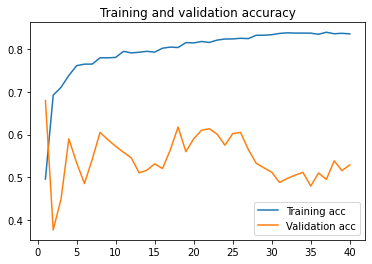

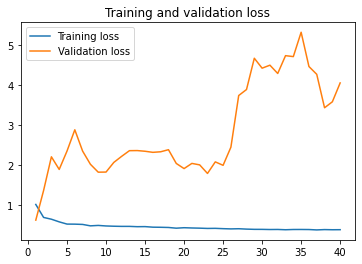

In [20]:
draw_train_graph(history)

In [27]:
model1.evaluate(x_test,y_test)

79/79 [==============================] - 2s 19ms/step - loss: 3.9062 - accuracy: 0.5367


[3.906248092651367, 0.5366826057434082]

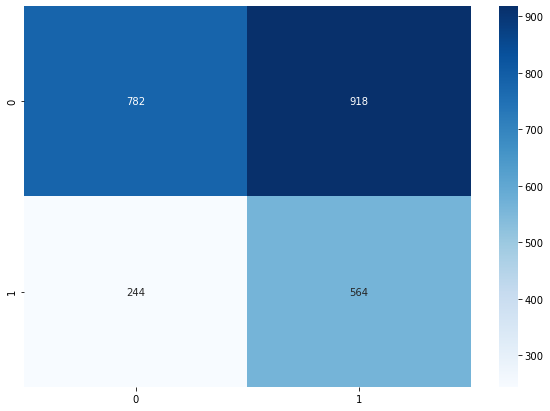

In [25]:
y_test_predict = draw_confusion_matrix(model1,x_test,y_test)

In [26]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.76      0.46      0.57      1700
      normal       0.38      0.70      0.49       808

    accuracy                           0.54      2508
   macro avg       0.57      0.58      0.53      2508
weighted avg       0.64      0.54      0.55      2508



In [29]:
model1.save('my_model/my_model1_acc54')

INFO:tensorflow:Assets written to: my_model/my_model1_acc54\assets


<a name="3.2"></a>

### model on oversampled data

In [40]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/'

In [41]:
train_generator,valid_generator = create_generators(train_path)

Found 10866 images belonging to 2 classes.
Found 2716 images belonging to 2 classes.


In [66]:
model2=build_model()
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_69 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_69 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_56 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_70 (Bat  (None, 109, 109, 64)   

In [59]:
history= train_model(model2 ,train_generator ,valid_generator)

Epoch 1/30
340/340 [==============================] - 392s 1s/step - loss: 0.4730 - accuracy: 0.7787 - val_loss: 1.4332 - val_accuracy: 0.6661
Epoch 2/30
340/340 [==============================] - 181s 532ms/step - loss: 0.4166 - accuracy: 0.8124 - val_loss: 23.3146 - val_accuracy: 0.3730
Epoch 3/30
340/340 [==============================] - 210s 618ms/step - loss: 0.3886 - accuracy: 0.8301 - val_loss: 0.3553 - val_accuracy: 0.8560
Epoch 4/30
340/340 [==============================] - 206s 607ms/step - loss: 0.3853 - accuracy: 0.8293 - val_loss: 63.0924 - val_accuracy: 0.2931
Epoch 5/30
340/340 [==============================] - 187s 551ms/step - loss: 0.3664 - accuracy: 0.8379 - val_loss: 822.2180 - val_accuracy: 0.4370
Epoch 6/30
340/340 [==============================] - 187s 551ms/step - loss: 0.3591 - accuracy: 0.8435 - val_loss: 1.6865 - val_accuracy: 0.8174
Epoch 7/30
340/340 [==============================] - 192s 565ms/step - loss: 0.3725 - accuracy: 0.8364 - val_loss: 0.6063 

In [60]:
model2.save('my_model2')

INFO:tensorflow:Assets written to: my_model2\assets


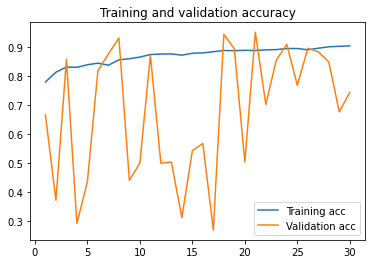

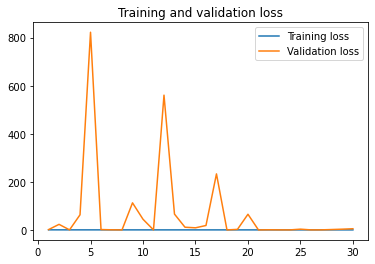

In [61]:
draw_train_graph(history)

In [7]:
model2=keras.models.load_model('my_model2')

In [8]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 23s 184ms/step - loss: 7.3414 - accuracy: 0.6770


[7.341413497924805, 0.6770334839820862]

<AxesSubplot:>

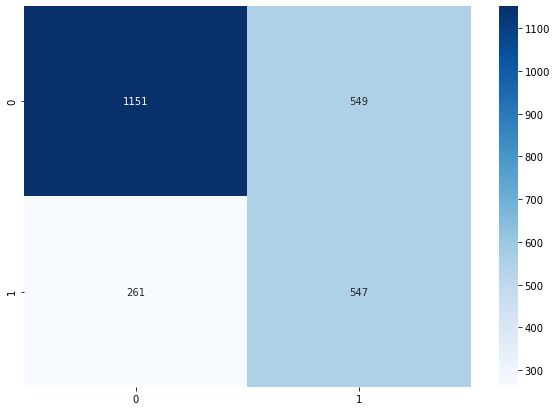

In [9]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [10]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

       close       0.82      0.68      0.74      1700
        open       0.50      0.68      0.57       808

    accuracy                           0.68      2508
   macro avg       0.66      0.68      0.66      2508
weighted avg       0.71      0.68      0.69      2508



<a name="3.3"></a>

### model on undersampled data

In [30]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/undersampled/'

In [31]:
train_generator,valid_generator = create_generators(train_path)

Found 5168 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


<a name="2"></a>

### build the model

In [32]:
model3=build_model()

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 64)    

<a name="2.1"></a>

### model complie & train

In [12]:
history=train_model(model3,train_generator,valid_generator)

Epoch 1/40
162/162 [==============================] - 248s 1s/step - loss: 0.6226 - accuracy: 0.7136 - val_loss: 80.6363 - val_accuracy: 0.5000
Epoch 2/40
162/162 [==============================] - 40s 249ms/step - loss: 0.5455 - accuracy: 0.7380 - val_loss: 59.5009 - val_accuracy: 0.5000
Epoch 3/40
162/162 [==============================] - 41s 252ms/step - loss: 0.4723 - accuracy: 0.7864 - val_loss: 29.6998 - val_accuracy: 0.5000
Epoch 4/40
162/162 [==============================] - 41s 255ms/step - loss: 0.4500 - accuracy: 0.7941 - val_loss: 30.5497 - val_accuracy: 0.6357
Epoch 5/40
162/162 [==============================] - 43s 268ms/step - loss: 0.4211 - accuracy: 0.8154 - val_loss: 6.8309 - val_accuracy: 0.4837
Epoch 6/40
162/162 [==============================] - 48s 295ms/step - loss: 0.3976 - accuracy: 0.8280 - val_loss: 1.3175 - val_accuracy: 0.6031
Epoch 7/40
162/162 [==============================] - 47s 290ms/step - loss: 0.3800 - accuracy: 0.8357 - val_loss: 354.9215 - va

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

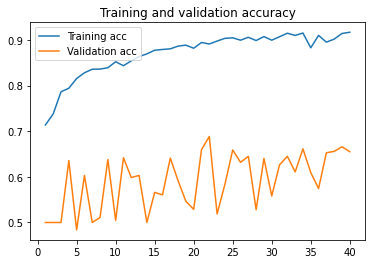

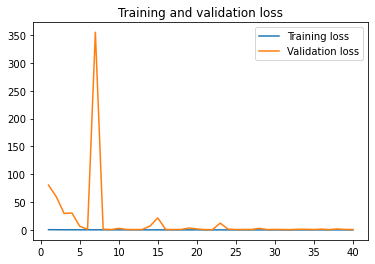

In [13]:
draw_train_graph(history)

In [14]:
model3.evaluate(x_test,y_test)

79/79 [==============================] - 2s 23ms/step - loss: 1.6089 - accuracy: 0.5546


[1.6088743209838867, 0.5546252131462097]

<AxesSubplot:>

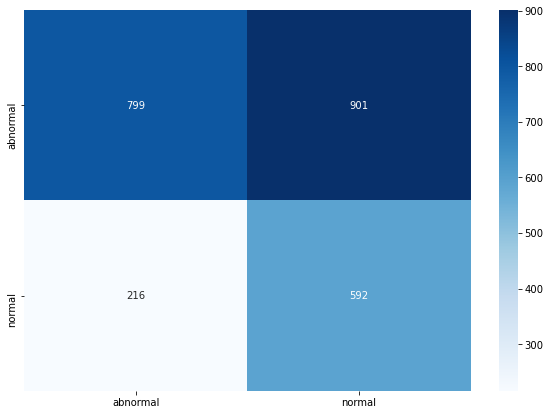

In [18]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [16]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

       close       0.79      0.47      0.59      1700
        open       0.40      0.73      0.51       808

    accuracy                           0.55      2508
   macro avg       0.59      0.60      0.55      2508
weighted avg       0.66      0.55      0.56      2508



In [19]:
model3.save('my_model3')

INFO:tensorflow:Assets written to: my_model3\assets


<a name="4"></a>
##  <span style="color:blue"> **train the model on the paper preprocessed data** </span>

<a name="4.1"></a>

### the model on preprocessed imbalanced data

In [32]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/imbalanced/'

In [33]:
train_generator,valid_generator = create_generators(train_path)

Found 8017 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


<a name="2"></a>

#### build the model

In [34]:
model4=build_model()

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 64)    

<a name="2.1"></a>

### model complie & train

In [35]:
history=train_model(model4,train_generator,valid_generator)

Epoch 1/40
502/502 [==============================] - 355s 705ms/step - loss: 0.9643 - accuracy: 0.5307 - val_loss: 0.7258 - val_accuracy: 0.4808 - lr: 1.0000e-08
Epoch 2/40
502/502 [==============================] - 65s 129ms/step - loss: 0.7695 - accuracy: 0.6549 - val_loss: 0.7472 - val_accuracy: 0.5052 - lr: 1.0007e-05
Epoch 3/40
502/502 [==============================] - 62s 124ms/step - loss: 0.7062 - accuracy: 0.6729 - val_loss: 1.1025 - val_accuracy: 0.4618 - lr: 2.0003e-05
Epoch 4/40
502/502 [==============================] - 67s 133ms/step - loss: 0.6413 - accuracy: 0.6978 - val_loss: 1.3788 - val_accuracy: 0.3545 - lr: 3.0000e-05
Epoch 5/40
502/502 [==============================] - 64s 128ms/step - loss: 0.5989 - accuracy: 0.7198 - val_loss: 0.7835 - val_accuracy: 0.4633 - lr: 2.9946e-05
Epoch 6/40
502/502 [==============================] - 63s 126ms/step - loss: 0.5824 - accuracy: 0.7324 - val_loss: 0.8646 - val_accuracy: 0.4533 - lr: 2.9784e-05
Epoch 7/40
502/502 [=======

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

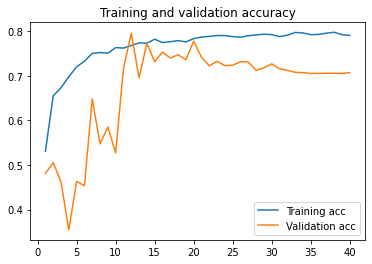

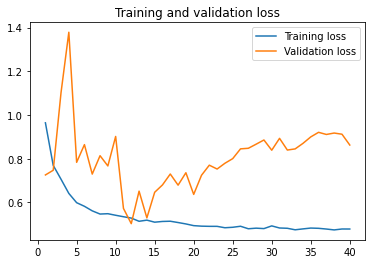

In [36]:
draw_train_graph(history)

In [37]:
model4.evaluate(x_test,y_test)

79/79 [==============================] - 8s 101ms/step - loss: 0.8752 - accuracy: 0.6866


[0.8751763105392456, 0.6866028904914856]

In [39]:
del train_generator
del valid_generator
gc.collect()

2842

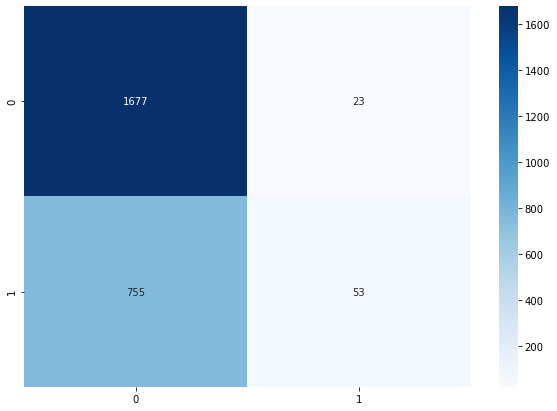

In [40]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [41]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.69      0.99      0.81      1700
      normal       0.70      0.07      0.12       808

    accuracy                           0.69      2508
   macro avg       0.69      0.53      0.47      2508
weighted avg       0.69      0.69      0.59      2508



In [42]:
model4.save('my_model/my_model4_acc69')

INFO:tensorflow:Assets written to: my_model/my_model4_acc69\assets


<a name="4.2"></a>

### the model on preprocessed oversampled data

In [13]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/oversampled/'

In [14]:
train_generator,valid_generator = create_generators(train_path)

Found 10866 images belonging to 2 classes.
Found 2716 images belonging to 2 classes.


<a name="2"></a>

### build the model

In [28]:
model5=build_model()

model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 64)    

<a name="2.1"></a>

### model complie & train

In [29]:
history=train_model(model5,train_generator,valid_generator)

Epoch 1/40
340/340 [==============================] - 256s 750ms/step - loss: 1.0647 - accuracy: 0.4732 - val_loss: 0.9158 - val_accuracy: 0.5000 - lr: 1.0000e-08
Epoch 2/40
340/340 [==============================] - 84s 247ms/step - loss: 0.6054 - accuracy: 0.7487 - val_loss: 0.3822 - val_accuracy: 0.8675 - lr: 1.0007e-05
Epoch 3/40
340/340 [==============================] - 83s 244ms/step - loss: 0.5347 - accuracy: 0.7740 - val_loss: 0.4154 - val_accuracy: 0.7971 - lr: 2.0003e-05
Epoch 4/40
340/340 [==============================] - 83s 243ms/step - loss: 0.5099 - accuracy: 0.7782 - val_loss: 0.4401 - val_accuracy: 0.7784 - lr: 3.0000e-05
Epoch 5/40
340/340 [==============================] - 83s 244ms/step - loss: 0.4837 - accuracy: 0.7857 - val_loss: 0.4901 - val_accuracy: 0.6808 - lr: 2.9946e-05
Epoch 6/40
340/340 [==============================] - 82s 242ms/step - loss: 0.4646 - accuracy: 0.7937 - val_loss: 0.5676 - val_accuracy: 0.5884 - lr: 2.9784e-05
Epoch 7/40
340/340 [=======

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

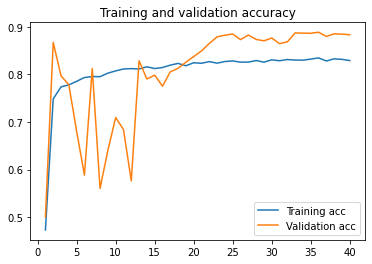

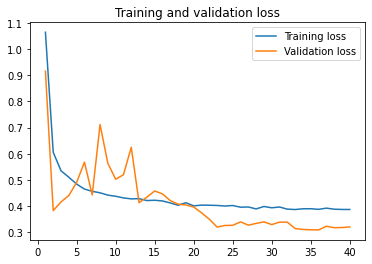

In [30]:
draw_train_graph(history)

<AxesSubplot:>

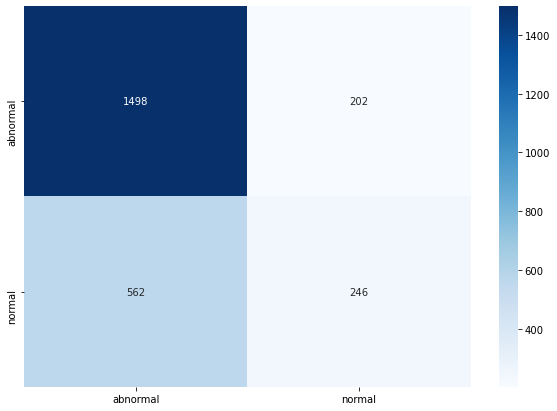

In [34]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [35]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.73      0.88      0.80      1700
      normal       0.55      0.30      0.39       808

    accuracy                           0.70      2508
   macro avg       0.64      0.59      0.59      2508
weighted avg       0.67      0.70      0.67      2508



In [32]:
model5.save('my_model5_acc88')

INFO:tensorflow:Assets written to: my_model5_acc88\assets


In [19]:
image=np.expand_dims(x_test[1],axis=0)

np.round(model5.predict(image))

array([[0.]], dtype=float32)

In [18]:
y_test[1]

0

<a name="4.3"></a>

### the model on undersampled preprocessed data

In [12]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/undersampled/'

In [16]:
train_generator ,valid_generator = create_generators(train_path)

Found 5168 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


In [14]:
model6=build_model()
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

In [19]:
history= train_model(model6 ,train_generator ,valid_generator)

Epoch 1/40
323/323 [==============================] - 221s 669ms/step - loss: 1.1598 - accuracy: 0.4420 - val_loss: 0.7304 - val_accuracy: 0.4868 - lr: 1.0000e-08
Epoch 2/40
323/323 [==============================] - 42s 129ms/step - loss: 0.7876 - accuracy: 0.6548 - val_loss: 0.5635 - val_accuracy: 0.7124 - lr: 1.0007e-05
Epoch 3/40
323/323 [==============================] - 41s 128ms/step - loss: 0.7577 - accuracy: 0.6527 - val_loss: 0.6015 - val_accuracy: 0.6302 - lr: 2.0003e-05
Epoch 4/40
323/323 [==============================] - 46s 141ms/step - loss: 0.7083 - accuracy: 0.6600 - val_loss: 0.5265 - val_accuracy: 0.7171 - lr: 3.0000e-05
Epoch 5/40
323/323 [==============================] - 41s 125ms/step - loss: 0.6972 - accuracy: 0.6592 - val_loss: 0.5586 - val_accuracy: 0.6566 - lr: 2.9946e-05
Epoch 6/40
323/323 [==============================] - 43s 133ms/step - loss: 0.6786 - accuracy: 0.6678 - val_loss: 0.5093 - val_accuracy: 0.7868 - lr: 2.9784e-05
Epoch 7/40
323/323 [=======

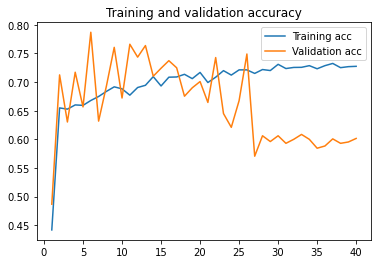

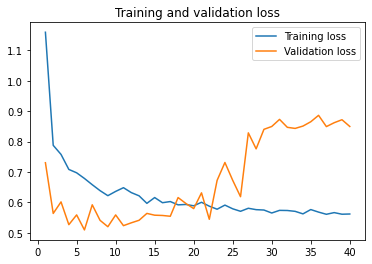

In [21]:
draw_train_graph(history)

In [23]:
model6.evaluate(x_test,y_test)

79/79 [==============================] - 2s 21ms/step - loss: 0.7437 - accuracy: 0.6898


[0.7436928749084473, 0.6897926926612854]

In [25]:
import gc
del train_generator
del valid_generator
gc.collect()


18765

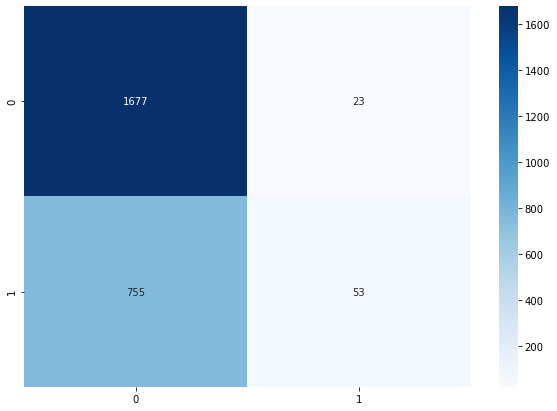

In [26]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [27]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.69      0.99      0.81      1700
      normal       0.70      0.07      0.12       808

    accuracy                           0.69      2508
   macro avg       0.69      0.53      0.47      2508
weighted avg       0.69      0.69      0.59      2508



In [31]:
model6.save('my_model/my_model6_acc69')

INFO:tensorflow:Assets written to: my_model/my_model6_acc69\assets
